In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# change directory to the root of the project
from os import chdir

chdir("../")


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pymannkendall as mk


In [4]:
station_id = 330020
year = 2022


In [5]:
# preprocessor component output
preprocessed_data = pd.read_parquet(
    f"data/output/stations/{station_id}/{year}_daily_temp_with_threshold.parquet",
)
preprocessed_data


,max_temp,90_percentile,90_percentile_adj,above_threshold
date,,,,
2022-01-01,29.9,33.30,33.278560,0
2022-01-02,31.0,32.55,33.294753,0
2022-01-03,32.6,32.90,33.309223,0
2022-01-04,32.4,33.50,33.321965,0
2022-01-05,32.3,32.30,33.332975,0
...,...,...,...,...
2022-12-27,30.5,32.60,33.165478,0
2022-12-28,32.2,32.50,33.190630,0
2022-12-29,34.4,32.75,33.214089,1


## Chile climate seasons

- Traditional point of view:

| season | start  |  end   |
| :----: | :----: | :----: |
| summer | Dec 21 | Mar 20 |
| autumn | Mar 20 | Jun 21 |
| winter | Jun 21 | Sep 21 |
| spring | Sep 21 | Dec 21 |

- With HANTS the objective is to divide winter/summer seasons according to the `max_temp` mean
  temperature of adjusted sin curve.


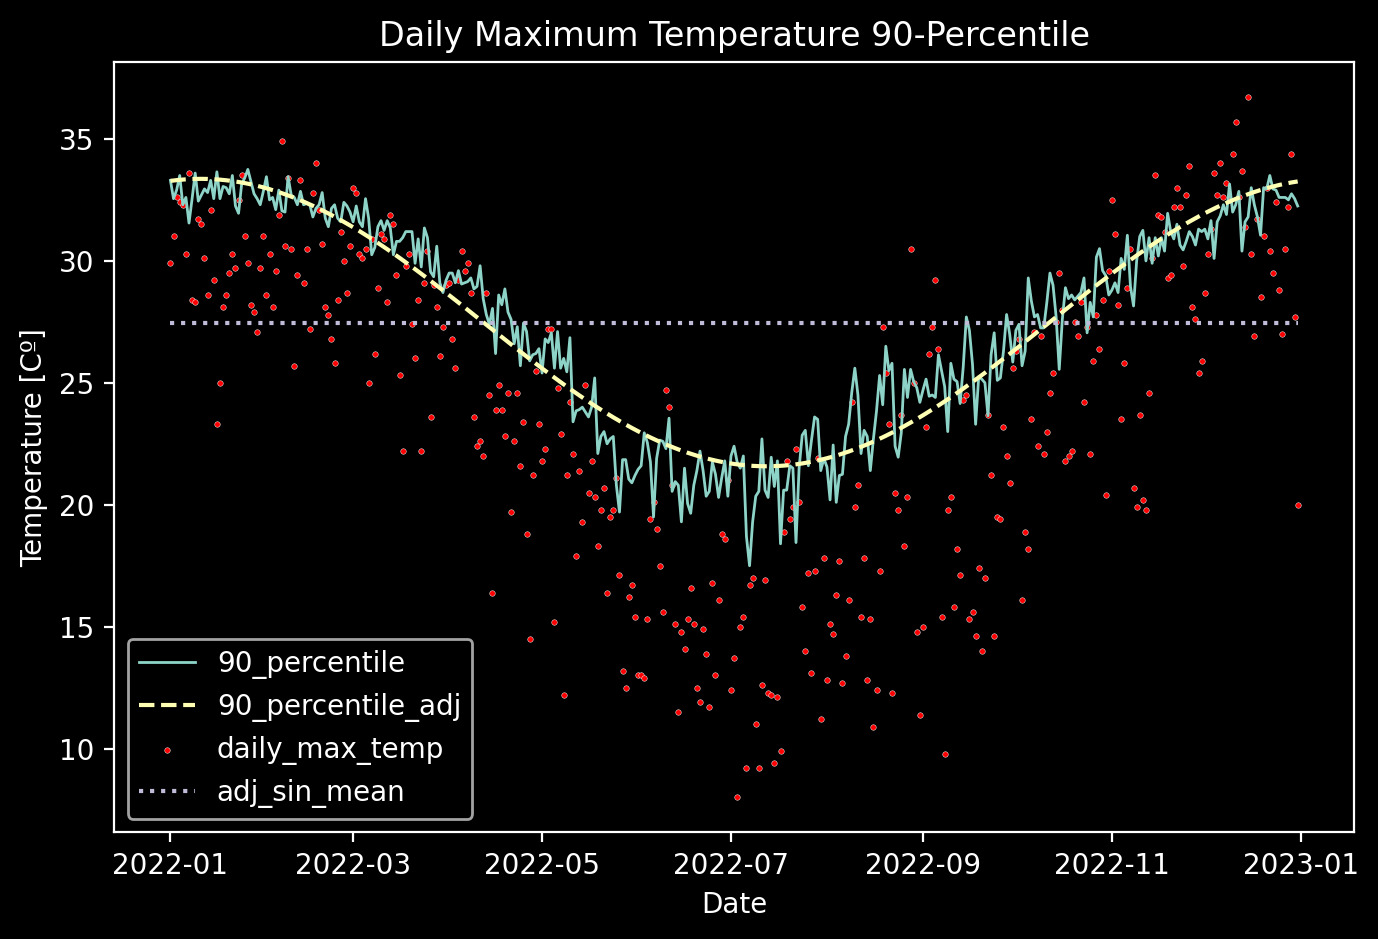

27.466301370159876

In [6]:
# plot 2022 year example with:
# - daily maximum temperature
# - 90-percentile (historic)
# - 90-percentile (historic) adjusted with sin function
# - adj sin function mean, that separates summer from winter data

import seaborn as sns


sin_mean = preprocessed_data["90_percentile_adj"].mean()

sns.lineplot(preprocessed_data, y="90_percentile", x="date", label="90_percentile", lw=1)
sns.lineplot(
    preprocessed_data,
    y="90_percentile_adj",
    x="date",
    label="90_percentile_adj",
    lw=1.5,
    ls="--",
)
sns.scatterplot(
    preprocessed_data,
    y="max_temp",
    x="date",
    label="daily_max_temp",
    color="red",
    s=4,
)
sns.lineplot(
    preprocessed_data,
    y=sin_mean,
    x="date",
    label="adj_sin_mean",
    lw=1.5,
    ls=":",
)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Maximum Temperature 90-Percentile")
plt.show()

sin_mean


In [9]:
def get_seasons_st_ed_dates(
    data: pd.DataFrame,
) -> tuple[pd.Timestamp, pd.Timestamp]:
    """Compute the days that separate summer from winter data.

    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed data with 90th percentile adjusted column "90_percentile_adj"].

    Returns
    -------
    tuple[pd.Timestamp, pd.Timestamp]
        Summer end date / Winter start date and Summer start date / Winter end date,
        respectively.
    """
    # get two dates from different months with the smallest difference between the 90th
    # percentile and the sin mean
    sin_mean = data["90_percentile_adj"].mean()
    ans = (data[["90_percentile_adj"]] - sin_mean).abs()
    ans.loc[:, "month"] = ans.index.month

    min_monthly_grouped_diffs = ans.groupby(["month"], as_index=True).min().reset_index(drop=True)
    min_monthly_diffs = (
        ans.reset_index()
        .merge(min_monthly_grouped_diffs, on="90_percentile_adj")
        .drop(columns=["month"])
        .set_index("date")
        .sort_values("90_percentile_adj")
    )
    return min_monthly_diffs.head(2).index.tolist()


def get_summer_winter_data(
    dt1: pd.Timestamp,
    dt2: pd.Timestamp,
    data: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Divides preprocessed data of an station into summer and winter data, according to
    the dates dt1 and dt2 obtained from the days intersection between adjusted sin function
    and 90th percentile.

    Parameters
    ----------
    dt1 : pd.Timestamp
        Summer end date / Winter start date.
    dt2 : pd.Timestamp
        Summer start date / Winter end date.
    data : pd.DataFrame
        Preprocessed data with 90th percentile adjusted column "90_percentile_adj"].

    Returns
    -------
    tuple[pd.DataFrame, pd.DataFrame]
        Summer and winter data, respectively.
    """
    summer_data = data[(data.index <= dt1) | (dt2 <= data.index)]
    winter_data = data[(dt1 < data.index) & (data.index < dt2)]
    return summer_data, winter_data


# seasonal data
summer_data, winter_data = get_summer_winter_data(
    *get_seasons_st_ed_dates(sin_mean, preprocessed_data),
    preprocessed_data,
)
summer_data.shape, winter_data.shape


In [ ]:
# compute yearly stat for summer/winter season
from hw_predictor.components.reporter.src.meteochile import (
    _compute_year_stats,
    _compute_agg_year_stats,
)

winter_ystats = _compute_year_stats(winter_data)
summer_ystats = _compute_year_stats(summer_data)

winter_agg_ystats = _compute_agg_year_stats(winter_ystats)
summer_agg_ystats = _compute_agg_year_stats(summer_ystats)

# winter_ystats
summer_ystats


,start,end,duration,mean_temp,min_temp,max_temp,sum_intensity
0,2022-12-04,2022-12-13,10,33.500000,32.5,35.7,18.35
1,2022-11-21,2022-11-23,3,32.466667,32.2,33.0,4.35
2,2022-11-15,2022-11-18,4,32.100000,31.2,33.5,5.90
3,2022-10-31,2022-11-02,3,31.066667,29.6,32.5,6.70
4,2022-04-04,2022-04-08,5,29.560000,28.7,30.4,3.60


In [ ]:
# winter_agg_ystats
summer_agg_ystats


,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration,hw_intensity,mean_hw_intensity,std_hw_intensity,max_hw_intensity,min_hw_intensity,hw_days,ratio_hw_per_day
year,,,,,,,,,,,,,,
2022,5,31.738667,35.7,28.7,5.0,10,3,38.9,7.78,6.034546,18.35,3.6,25.0,0.013699


In [ ]:
winter_agg_ystats


,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration,hw_intensity,mean_hw_intensity,std_hw_intensity,max_hw_intensity,min_hw_intensity,hw_days,ratio_hw_per_day
year,,,,,,,,,,,,,,
2022,2,26.304167,29.2,23.3,3.5,4,3,16.1,8.05,2.192031,9.6,6.5,7.0,0.005479
